In [ ]:
import numpy as np
import scipy as sp
import time, sys
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

#mu1,mu2a=np.meshgrid(np.linspace(0,0.3,24),np.linspace(0,0.3,24),indexing='ij')
#mu1b,mu2=np.meshgrid(np.linspace(0.01,0.6,24),np.linspace(0.01,0.6,24),indexing='ij')
mu1,mu2a=np.meshgrid(np.linspace(0.,0.1,24),np.linspace(0.0,0.1,24),indexing='ij')
mu1b,mu2=np.meshgrid(np.linspace(0.1,0.6,24),np.linspace(0.1,0.6,24),indexing='ij')
mu_convX = 0.1

mu1=mu1.flatten()
mu2=mu2.flatten()
no_para=np.size(mu1,axis=0) 

N=120
Ns=(N-1)**2
Nt=50
h=1./N
Tfinal = 1.#3.
k=Tfinal/Nt
x1,x2=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom
u0 = 0*x1 #100*np.exp( -( ((x1-0.3)/0.125)**2 + ((x2-0.3)/0.125)**2) ) #IC of problem
u0 = u0.flatten()
x1=x1.flatten()
x2=x2.flatten()
t=np.linspace(0,Tfinal,Nt+1)

e=np.ones(N-1)
A1D_diff=1/h**2*sp.sparse.spdiags(np.vstack((e,-2*e,e)),[-1,0,1],N-1,N-1,format='csc') #twice differentiation
A2D_diff=sp.sparse.kron(A1D_diff,sp.sparse.eye(N-1,format='csc'),format='csc')+sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D_diff,format='csc')
A1D_conv=1/(h)*sp.sparse.spdiags(np.vstack((-1*e,1*e,0*e)),[-1,0,1],N-1,N-1,format='csc') 
A2D_conv=sp.sparse.kron(A1D_conv,sp.sparse.eye(N-1,format='csc'),format='csc') + \
         mu_convX*sp.sparse.kron(sp.sparse.eye(N-1,format='csc'),A1D_conv,format='csc')
I=sp.sparse.eye(Ns,format='csc')

# High-fidelity
U=np.zeros((Ns,no_para*Nt))
f=np.zeros((Ns,Nt+1))
for i in range(Nt+1):
    f[:,i] = 100*np.exp( -( ((x2-0.5+(0.2*np.sin(2*np.pi*t[i])))/0.01)**2 + ((x1-0)/0.05)**2)    )
FOM_t_start=time.time()
for p in range(no_para):
    A= -mu2[p]*A2D_conv + mu1[p]*A2D_diff 
    u=np.zeros((Ns,Nt+1))
    u[:,0] = u0
    for n in range(Nt):
        u[:,n+1]=spsolve(I-k*A,u[:,n]+k*f[:,n+1])     
    U[:,np.arange(p*Nt,(p+1)*Nt)]=u[:,1:]
FOM_t_elapsed=time.time()-FOM_t_start
# POD of solution snapshot
W,S,VT=np.linalg.svd(U)


In [ ]:
import time
# Generate ROM basis
ns=60
PHIs=W[:,:ns]
PHIsT=PHIs.T

# construct Djk
nt=20 #40
D=np.zeros((ns,nt*Nt))
for i in range(ns):
    Ri=VT[i,:]
    Ri=Ri.reshape(-1,no_para,order='F')
    Wi,Si,ViT=np.linalg.svd(Ri)
    PHIti=Wi[:,:nt]
    for j in range(nt):
        D[i,Nt*j:Nt*(j+1)]=PHIti[:,j]
        
# construct PHIst
PHIst=np.zeros((Ns*Nt,ns*nt))
for i in range(Nt):
    for j in range(nt):
        PHIstij=np.zeros((Ns,ns))
        Dij=sp.sparse.diags(D[:,j*Nt+i],format='csc')
        PHIst[Ns*i:Ns*(i+1),ns*j:ns*(j+1)]=PHIs@Dij  
PHIstT=PHIst.T

# Run Space-Time ROM for arbitrary parameter
mu=[0.2,0.001]# set parameter mu
A= -mu[0]*A2D_conv + mu[1]*A2D_diff
f=np.zeros((Ns,Nt+1))
for i in range(Nt+1):
    f[:,i] = 100*np.exp( -( ((x2-0.5+(0.2*np.sin(2*np.pi*t[i])))/0.01)**2 + ((x1-0)/0.05)**2)    )
# construct Ast and fst
As=PHIsT@A@PHIs
fs=PHIsT@f
us0=PHIsT@u0
Ast=np.zeros((ns*nt,ns*nt))
for i in range(nt):
    for j in range(nt):
        Astij=np.zeros((ns,ns))
        for kk in range(Nt):
            Dik=sp.sparse.diags(D[:,i*Nt+kk],format='csc')
            Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
            Astij+=Dik@Djk-k*Dik@As@Djk
        for kk in range(Nt-1):
            Dik_next=sp.sparse.diags(D[:,i*Nt+kk+1],format='csc')
            Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
            Astij-=Dik_next@Djk   
        Ast[ns*i:ns*(i+1),ns*j:ns*(j+1)]=Astij  
fst=np.zeros(ns*nt)
for j in range(nt):
    for kk in range(Nt):
        Djk=sp.sparse.diags(D[:,j*Nt+kk],format='csc')
        fst[ns*j:ns*(j+1)]+=k*Djk@fs[:,kk+1]
ust=np.zeros(ns*nt)
for j in range(nt):
    Djk=sp.sparse.diags(D[:,j*Nt],format='csc')
    ust[ns*j:ns*(j+1)] += Djk@us0
    
# Space-Time ROM
ROM_t_start=time.time()
UstROM=PHIst@np.linalg.solve(Ast,ust+fst)
ROM_t_elapsed1=time.time()-ROM_t_start

# Run HF model to check error when a parameter set is arbitary
mu=[0.2,0.001] # set parameter mu
A= -mu[0]*A2D_conv + mu[1]*A2D_diff

u=np.zeros((Ns,Nt+1))
u[:,0] = u0
f=np.zeros((Ns,Nt+1))
for i in range(Nt+1):
    f[:,i] = 100*np.exp( -( ((x2-0.5+(0.2*np.sin(2*np.pi*t[i])))/0.01)**2 + ((x1-0)/0.05)**2)    )

HF_t_start=time.time()
for n in range(Nt):
    u[:,n+1]=spsolve(I-k*A,u[:,n]+k*f[:,n+1])
HF_t_elapsed=time.time()-HF_t_start
UstHF=u[:,1:].flatten(order='F')

In [ ]:
# Print results
print('max difference1',np.max(UstHF-UstROM),'min difference1',np.min(UstHF-UstROM))
print('relative error1(%)',np.linalg.norm(UstROM-UstHF)/np.linalg.norm(UstHF)*100)
print('speed-up1',HF_t_elapsed/ROM_t_elapsed1)
print('High Fidelity Model', HF_t_elapsed)
print('ROM Model', ROM_t_elapsed1)
print('training time', FOM_t_elapsed)

#find residual
print(f.shape)
#U_ROM = np.reshape(UstHF,(Ns,Nt),order="F") #UstHF.reshape(Ns,Nt)
U_ROM = np.reshape(UstROM,(Ns,Nt),order="F")
U_ROMpIC = np.zeros((Ns,Nt+1))
U_ROMpIC[:,1:] = U_ROM
resid=np.zeros((Ns,Nt))
for n in range(Nt):
  resid[:,n]=(I-k*A)*U_ROMpIC[:,n+1]-(U_ROMpIC[:,n]+k*f[:,n+1])
resid_st = resid.flatten(order="F")
print(np.linalg.norm(resid_st))

In [ ]:
import os
from matplotlib.colors import LogNorm

save_figures = False
directory = 'plots2'
#if directory doesn't exist, create it
if save_figures:
    if not os.path.exists(os.path.join(os.getcwd(), directory)):
        os.mkdir(os.path.join(os.getcwd(), directory))

U_orig = np.reshape(UstHF,(Ns,Nt),order="F") #UstHF.reshape(Ns,Nt)
U_ROM = np.reshape(UstROM,(Ns,Nt),order="F")
u_orig = u[:,1:]
xx,yy=np.meshgrid(np.linspace(0,1,N+1)[1:-1],np.linspace(0,1,N+1)[1:-1],indexing='ij') # only free degrees of freedom

relative_error = np.zeros(Nt)
for i in range(Nt):
    relative_error[i] = np.linalg.norm(U_ROM[:,i]-U_orig[:,i])/np.linalg.norm(U_orig[:,i]) 
    #relative_error[i] = np.max(np.abs(U_ROM[:,i]-U_orig[:,i]))/np.linalg.norm(U_orig[:,i])
    
plt.figure()
t=np.linspace(0,Tfinal,Nt+1)
time = t[1:]
plt.semilogy(time,relative_error,'k-o')
plt.xlabel(r'Time',fontsize=16)
plt.ylabel(r'Relative Error',fontsize=16)
plt.xticks([0,0.25,0.5,0.75,1.0],fontsize=12)
plt.yticks([1e-3,5e-3,1e-2],fontsize=12)
plt.ylim([1e-3,1e-2])
np.savetxt(os.path.join(os.getcwd(), directory,"relative_error_file.txt"),relative_error)
print(relative_error[0])
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "petrovgalerkin_error_vs_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()

index = 19
fig=plt.figure()
cmap = plt.cm.plasma
plt.pcolormesh(xx,yy,U_ROM[:,index].reshape(N-1,N-1),norm=LogNorm(),linewidth=0,rasterized=True,cmap = cmap)
#plt.colorbar()
plt.clim([1e-3,1e1])
cbar = plt.colorbar()#ticks=[0,3,6])#, label=['0','-0.005','-0.010','-0.015'])
cbar.ax.tick_params(labelsize=12) 
plt.xlabel(r'x',fontsize=16)
plt.ylabel(r'y',fontsize=16)
plt.title(r'Final Time',fontsize=16)
plt.xticks([0,0.25,0.50,0.75,1.0],fontsize=12)
plt.yticks([0,0.25,0.50,0.75,1.0],fontsize=12)
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "petrovgalerkin_pcolor_final_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()
print(U_ROM[:,index])
    
index = 19
fig=plt.figure()
cmap = plt.cm.plasma
plt.pcolormesh(xx,yy,U_orig[:,index].reshape(N-1,N-1),norm=LogNorm(),linewidth=0,rasterized=True,cmap = cmap)
#plt.colorbar()
plt.clim([1e-3,1e1])
cbar = plt.colorbar()#ticks=[0,3,6])#, label=['0','-0.005','-0.010','-0.015'])
cbar.ax.tick_params(labelsize=12) 
plt.xlabel(r'x',fontsize=16)
plt.ylabel(r'y',fontsize=16)
plt.title(r'Final Time',fontsize=16)
plt.xticks([0,0.25,0.50,0.75,1.0],fontsize=12)
plt.yticks([0,0.25,0.50,0.75,1.0],fontsize=12)
if save_figures:
    plt.savefig(os.path.join(os.getcwd(), directory, "petrovgalerkin_pcolor_final_time"),
                        dpi=200, bbox_inches='tight',format='eps')
else:
    plt.show()

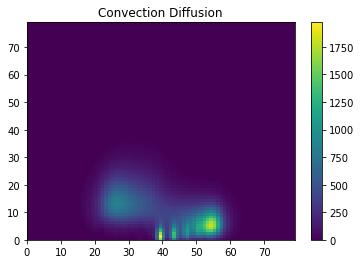

In [4]:
# First set up the figure, the axis, and the plot element we want to animate
from matplotlib import animation, rc
from IPython.display import HTML

ti = 0
title = 'Convection Diffusion'
u_mx = np.max(np.abs(U_ROM[:,0].reshape(N-1,N-1)))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(title)
#cmap = plt.cm.ocean
img = ax.pcolormesh(U_ROM[:,0].reshape(N-1,N-1), vmin=0, vmax=u_mx)
fig.colorbar(img, orientation='vertical')
#plt.show()

# initialization function: plot the background of each frame
def init():
    img = ax.pcolormesh(U_ROM[:,0].reshape(N-1,N-1), vmin=0, vmax=u_mx)
    return (fig,)

# animation function. This is called sequentially
def animate(i):
    u_mx = np.max(np.abs(U_ROM[:,i].reshape(N-1,N-1)))
    img = ax.pcolormesh(U_ROM[:,i].reshape(N-1,N-1), vmin=0, vmax=u_mx)
    return (fig,)

# call the animator. blit=True means only re-draw the parts that have changed.
plt.rcParams['animation.ffmpeg_path'] = '/opt/anaconda2/bin/ffmpeg'
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=1, blit=True)

writer = animation.writers['ffmpeg'](fps=1)
HTML(anim.to_html5_video())


In [5]:

# animation function. This is called sequentially
#def animate(i):
#    img = ax.imshow(U_ROM[:,i].reshape(N-1,N-1), vmin=-u_mx, vmax=u_mx)
#    return (fig,)

anim.save('conv_diff.mp4', fps=30, extra_args=['-vcodec', 'libx264'])